In [ ]:
from google.colab import drive

drive.mount("/content/gdrive/")

In [ ]:
cd /content/gdrive/MyDrive/classification/

# Exploration

## Agenda
1. Split the raw data into initial features (classification and content)
2. View summary statistics of spam and non-spam sms content
3. Convert the raw data into tabular format

In [1]:
import pandas as pd

In [ ]:
# Split raw data from file into classification and sms content arrays
spam:list = []
text:list = []

with open("SMSSpamCollection") as file:
    for line in file.readlines():
        # Extract classification prefix from line
        prefix:str = line.split()[0]

        # Converts the two class names into boolean format where "spam" is true
        spam_bool = lambda x: True if prefix == "spam" else False

        # Add the row instance to each feature array
        spam.append(spam_bool(prefix))
        text.append(line.removeprefix(prefix)[1:-1])

In [ ]:
# Load classification and sms content into dataframe object for future handling
spam_df = pd.DataFrame(
    {
        "Spam":spam,
        "Text":text
    }
)

In [ ]:
print(spam_df.shape)
spam_df.head()

(5574, 2)


,Spam,Text
0,False,"Go until jurong point, crazy.. Available only ..."
1,False,Ok lar... Joking wif u oni...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...
3,False,U dun say so early hor... U c already then say...
4,False,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
spam_df.groupby("Spam").describe()

Text                                                               
      count unique                                                top freq
Spam                                                                      
False  4827   4518                             Sorry, I'll call later   30
True    747    653  Please call our customer service representativ...    4

In [ ]:
# Export cleaned dataset to new csv document
spam_df.to_csv(
    path_or_buf="spam.csv", 
    index=False
)

# Preprocessing

# Agenda
1. Identify the tokens/rules that will be used to split the content into words
2. Convert SMS content into word vectors

In [ ]:
# Import cleaned dataset
spam_df = pd.read_csv(
    filepath_or_buffer="./spam.csv"
    )

## Tokens
From: Almeida, T. A., Hidalgo, J. M. G., & Yamakami, A. (2011, September). Contributions to the study of SMS spam filtering: new collection and results. In Proceedings of the 11th ACM symposium on Document engineering (pp. 259-262).
1. tokens start with a printable character, followed by any number of alphanumeric characters, excluding dots, commas and colons  from the middle of the pattern.
2. any sequence of characters separated by blanks, tabs, returns, dots, commas, colons and dashes are considered as tokens.

### Criticism
The tokens described in the paper do not adequately capture the words for this data as some uncecessary punctuation is included.

**Example:**
> ``` Python
> # Example sentences
> "I was under-prepared."
> "I was under-prepared?"
> "I was under-prepared!"
> 
> tok1 = "I", "was", "under-prepared"
> tok1 = "I", "was", "under-prepared?"
> tok1 = "I", "was", "under-prepared!"
> 
> tok2 = "I", "was", "under", "prepared"
> tok2 = "I", "was", "under", "prepared?"
> tok2 = "I", "was", "under", "prepared!"
> ```

**Expectation:**
> ``` Python
> "I was under-prepared."
> "I was under-prepared?"
> "I was under-prepared!"
>
> tok = "I", "was", "under", "prepared"
> tok = "I", "was", "under", "prepared"
> tok = "I", "was", "under", "prepared"
> ```

### Solution
[Regular expression solution from sklearn library](https://github.com/scikit-learn/scikit-learn/blob/d5082d32d/sklearn/feature_extraction/text.py#L350): `(?u)\b\w\w+\b`

This method converts all sentences in the corpus to lower case and only retrieves alphanumeric characters.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Return matrix of tfidf score for each configuration of documents (rows) and words (columns)
vectorizer = TfidfVectorizer()
spam_sparse = vectorizer.fit_transform(spam_df["Text"])
spam_dense = spam_sparse.todense()

In [ ]:
feature_names = vectorizer.get_feature_names_out()

## Export Results

In [ ]:
spam_vec = pd.DataFrame(
    spam_dense, columns=feature_names
)

In [ ]:
spam_vec.to_csv(
    path_or_buf="spam_vec.csv", index=False
)

# Modelling

## Agenda
1. Split the data into training and testing sets
2. Train the models
3. Evaluate model performance

In [2]:
# Import training and testing attributes
X = pd.read_csv(
    filepath_or_buffer="spam_vec.csv"
)
y = pd.read_csv(
    filepath_or_buffer="spam.csv"
)["Spam"]

In [3]:
import tensorflow as tf
from keras.layers import Dense, Input
from sklearn.svm import SVC

### Classifier Hyperparameter Configuration

In [4]:
# Configure neural network hyperparameters
input_dim:int = X.shape[1]

n_neurons_1:int = 128
n_neurons_2:int = 128
n_neurons_3:int = 128

output_dim:int = 1

epoch_no:int = 10
batch_size:int = 512

In [5]:
# Add layers and activation function to neural network
nn_model = tf.keras.Sequential()

nn_model.add(Dense(input_dim, activation="relu"))
nn_model.add(Dense(n_neurons_1, activation="relu"))
nn_model.add(Dense(n_neurons_2, activation="relu"))
nn_model.add(Dense(n_neurons_3, activation="relu"))
nn_model.add(Dense(output_dim, activation="relu"))

# Configure loss function, gradient descent, and evaluation metrics
nn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [6]:
# Configure support vector machine hyperparameters
svm_model = SVC(
    kernel="rbf"
)

In [7]:
from sklearn.model_selection import train_test_split

### Model Training

In [8]:
# Train split: used to learn and optimize the hyperplane used for classification task
# Test split: evaluate the learned model predictions against new values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# Learn classification hyperplane
svm_model.fit(
    X=X_train, y=y_train
)
nn_model.fit(
    X_train, y_train, epochs=epoch_no, batch_size=batch_size
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8853 - loss: 0.6229
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9903 - loss: 0.0637
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9970 - loss: 0.0204
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9992 - loss: 0.0143
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9993 - loss: 0.0107
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9987 - loss: 0.0215
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9992 - loss: 0.0123
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9985 - loss: 0.0242
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9987 - loss: 0.0217
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9989 - loss: 0.0170


### Model Predictions

In [10]:
svm_pred = svm_model.predict(X_test)
nn_pred = nn_model.predict(X_test) > 0.5    # Convert predictions to boolean attributes

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


### Model Evaluation

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

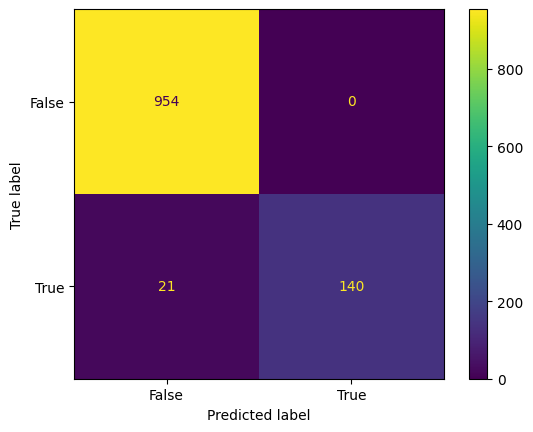

In [12]:
# Plot the confusion matrix of the SVM model
cm = confusion_matrix(y_true=y_test, y_pred=svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

disp.plot()
plt.show()

In [13]:
print("SVM Classification Report")
print(
    classification_report(y_true=y_test, y_pred=svm_pred)
)

SVM Classification Report
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       954
        True       1.00      0.87      0.93       161

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



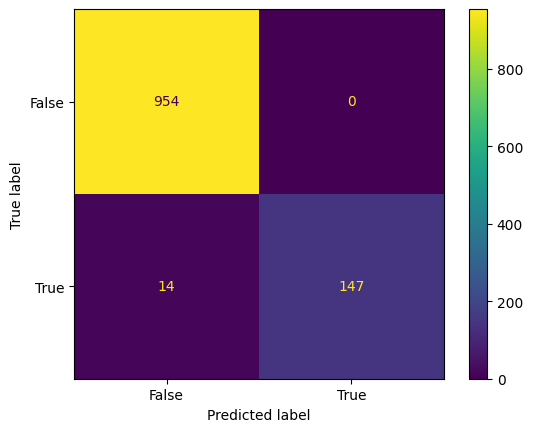

In [17]:
# Plot the confusion matrix of the SVM model
cm = confusion_matrix(y_true=y_test, y_pred=nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])

disp.plot()
plt.show()

In [18]:
print("Neural Network Classification Report")
print(
    classification_report(y_true=y_test, y_pred=nn_pred)
)

Neural Network Classification Report
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       954
        True       1.00      0.91      0.95       161

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

